# TNT Single-Mode: Startup Shear

## Learning Objectives
1. Understand stress overshoot in transient network materials
2. Fit TNT single-mode model to startup shear data
3. Analyze conformation tensor evolution during startup
4. Predict stress overshoot at different shear rates
5. Extract network relaxation time from overshoot dynamics
6. Perform Bayesian inference for parameter uncertainty

## Prerequisites
- Understanding of transient network theory (Notebook 01)
- Familiarity with time-dependent rheology
- Knowledge of stress overshoot phenomena

## Runtime Estimate
- NLSQ fitting: ~3-8 seconds
- Bayesian inference (demo): ~45-90 seconds
- Total: ~3-5 minutes

## 1. Setup

In [1]:
import os
import sys
import time

# Google Colab support
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax

import numpy as np
import matplotlib.pyplot as plt
import arviz as az

from rheojax.core.jax_config import safe_import_jax
jax, jnp = safe_import_jax()
from rheojax.core.jax_config import verify_float64
verify_float64()

from rheojax.models.tnt import TNTSingleMode

sys.path.insert(0, os.path.join("..", "utils"))
from tnt_tutorial_utils import (
    load_pnas_startup,
    compute_fit_quality,
    print_convergence_summary,
    print_parameter_comparison,
    save_tnt_results,
    get_tnt_single_mode_param_names,
    plot_conformation_tensor_evolution,
    get_bayesian_config,
)

## 2. Theory

## Stress Overshoot in Transient Networks

### Physical Mechanism

When a sudden shear rate is applied to a transient network:
1. **Initial phase**: Network strands stretch elastically → stress increases rapidly
2. **Overshoot**: Stress reaches maximum when strand creation/breakage balance is disrupted
3. **Relaxation**: Network reorganizes, stress decreases to steady-state value

### Governing Equations

The conformation tensor **S** evolves according to:

$$
\frac{dS}{dt} = \mathbf{L} \cdot \mathbf{S} + \mathbf{S} \cdot \mathbf{L}^T + g_0 \mathbf{I} - \beta \mathbf{S}
$$

Stress is computed from:

$$
\boldsymbol{\sigma} = G (\mathbf{S} - \mathbf{I}) + \eta_s \mathbf{D}
$$

where $\mathbf{D}$ is the rate of deformation tensor.

### Steady-State Stress

At steady state (t → ∞):

$$
\sigma_{ss} = G \tau_b \dot{\gamma} + \eta_s \dot{\gamma}
$$

### Overshoot Characteristics

- **Peak time**: Occurs at $t_{peak} \approx \tau_b$ (one relaxation time)
- **Peak stress**: $\sigma_{peak} > \sigma_{ss}$
- **Overshoot ratio**: $\sigma_{peak}/\sigma_{ss}$ depends on Wi = $\dot{\gamma} \tau_b$

### Parameters

| Parameter | Symbol | Physical Meaning | Typical Range |
|-----------|--------|------------------|---------------|
| Elastic modulus | $G$ | Network stiffness | 1-1000 Pa |
| Breakage time | $\tau_b$ | Crosslink lifetime | 0.01-100 s |
| Solvent viscosity | $\eta_s$ | Background viscosity | 0.001-1 Pa·s |

## 3. Load Data

In [2]:
# Load startup shear data
gamma_dot = 1.0  # s^-1
t_data, stress = load_pnas_startup(gamma_dot=gamma_dot)

print(f"Data shape: {len(t_data)} points")
print(f"Time range: {t_data.min():.3f} - {t_data.max():.3f} s")
print(f"Stress range: {stress.min():.2f} - {stress.max():.2f} Pa")
print(f"Applied shear rate: {gamma_dot} s⁻¹")

Data shape: 50 points
Time range: 0.005 - 59.996 s
Stress range: 0.69 - 26.82 Pa
Applied shear rate: 1.0 s⁻¹


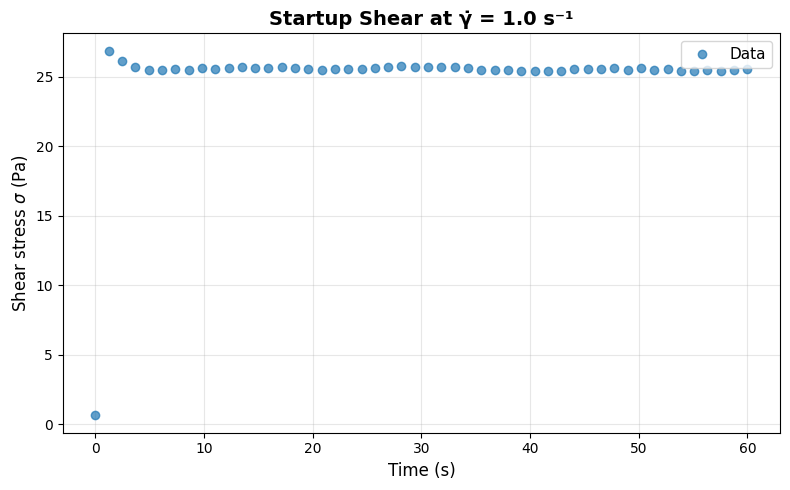


Overshoot Analysis:
  Peak stress: 26.82 Pa at t = 1.226 s
  Steady-state stress: 25.50 Pa
  Overshoot ratio: 1.05


In [3]:
# Plot raw data
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t_data, stress, 'o', label='Data', markersize=6, alpha=0.7)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel(r'Shear stress $\sigma$ (Pa)', fontsize=12)
ax.set_title(f'Startup Shear at γ̇ = {gamma_dot} s⁻¹', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Identify overshoot
peak_idx = np.argmax(stress)
peak_time = t_data[peak_idx]
peak_stress = stress[peak_idx]
steady_stress = np.mean(stress[-10:])
overshoot_ratio = peak_stress / steady_stress

print(f"\nOvershoot Analysis:")
print(f"  Peak stress: {peak_stress:.2f} Pa at t = {peak_time:.3f} s")
print(f"  Steady-state stress: {steady_stress:.2f} Pa")
print(f"  Overshoot ratio: {overshoot_ratio:.2f}")

## 4. NLSQ Fitting

In [4]:
# Create model and fit
model = TNTSingleMode(breakage="constant")

start_time = time.time()
result = model.fit(t_data, stress, test_mode="startup", gamma_dot=gamma_dot, method='scipy')
fit_time = time.time() - start_time

print(f"\nNLSQ fitting completed in {fit_time:.2f} seconds")
print(f"\nFitted Parameters:")
param_names = get_tnt_single_mode_param_names(breakage="constant")
for name in param_names:
    param = model.parameters.get(name)
    print(f"  {name} = {param.value:.4e}")


NLSQ fitting completed in 89.13 seconds

Fitted Parameters:
  G = 2.5042e+02
  tau_b = 9.9486e-02
  eta_s = 6.8850e-01


In [5]:
# Compute fit quality metrics
metrics = compute_fit_quality(stress, model.predict(t_data, test_mode="startup", gamma_dot=gamma_dot))
print(f"\nFit Quality:")
print(f"  R² = {metrics['R2']:.6f}")
print(f"  RMSE = {metrics['RMSE']:.4e} Pa")
print(f"  NRMSE = {metrics['NRMSE']*100:.2f}%")


Fit Quality:
  R² = 0.996203
  RMSE = 2.1537e-01 Pa
  NRMSE = 0.82%


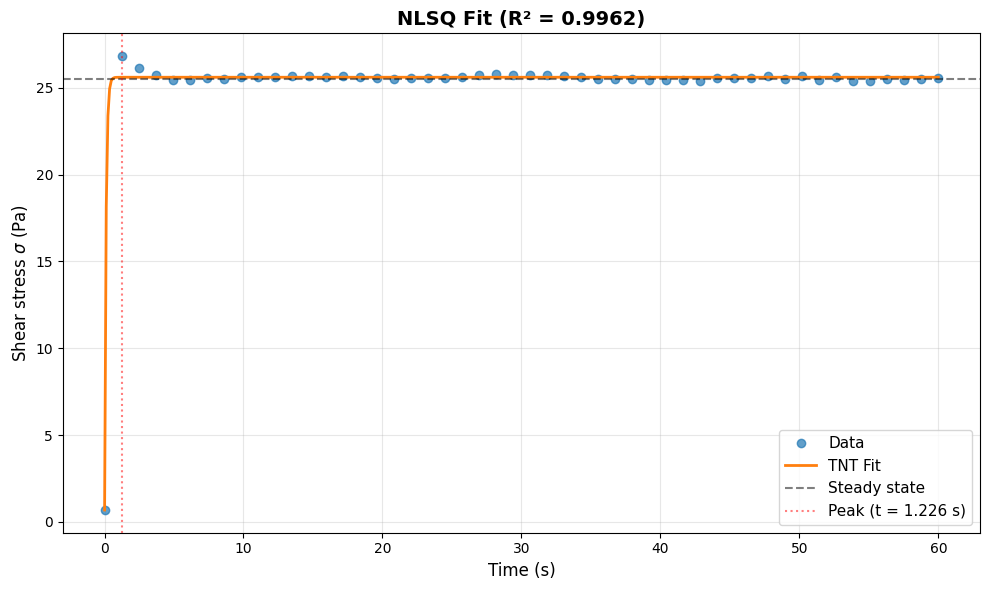

In [6]:
# Plot fit overlay
time_fine = np.linspace(t_data.min(), t_data.max(), 500)
stress_pred = model.simulate_startup(time_fine, gamma_dot=gamma_dot)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_data, stress, 'o', label='Data', markersize=6, alpha=0.7)
ax.plot(time_fine, stress_pred, '-', label='TNT Fit', linewidth=2)
ax.axhline(y=steady_stress, color='k', linestyle='--', alpha=0.5, label='Steady state')
ax.axvline(x=peak_time, color='r', linestyle=':', alpha=0.5, label=f'Peak (t = {peak_time:.3f} s)')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel(r'Shear stress $\sigma$ (Pa)', fontsize=12)
ax.set_title(f'NLSQ Fit (R² = {metrics["R2"]:.4f})', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4.2 Physical Analysis

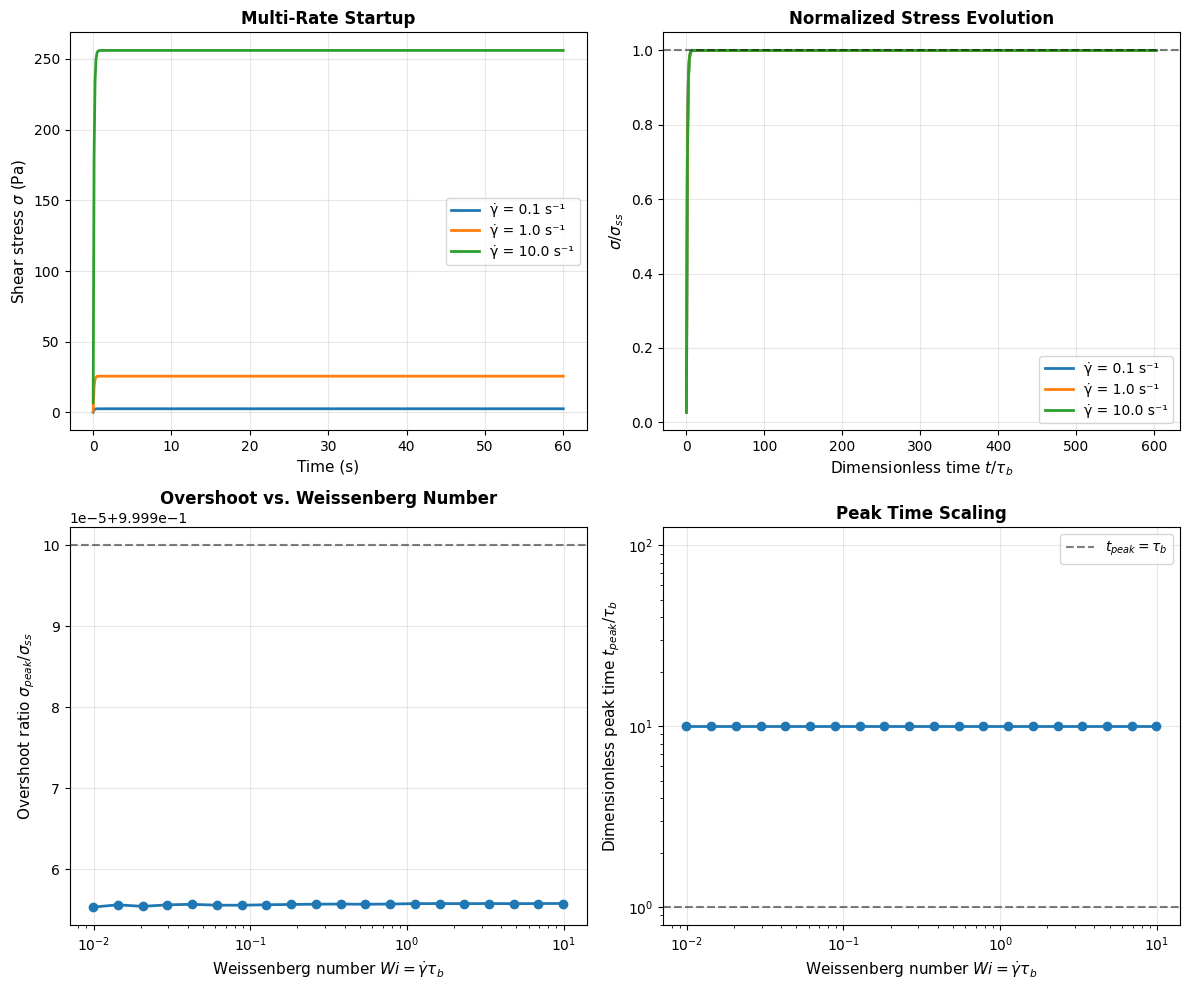


Physical Interpretation:
  Network modulus: G = 250.42 Pa
  Breakage time: τ_b = 0.0995 s
  Peak occurs at t ≈ τ_b = 0.0995 s (one relaxation time)
  Steady-state stress: σ_ss = G·τ_b·γ̇ + η_s·γ̇ = 25.60 Pa


In [7]:
# Extract fitted parameters
G = model.parameters.get('G').value
tau_b = model.parameters.get('tau_b').value
eta_s = model.parameters.get('eta_s').value

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Multi-rate startup predictions
ax = axes[0, 0]
gamma_dot_list = [0.1, 1.0, 10.0]
colors = ['C0', 'C1', 'C2']
for gd, color in zip(gamma_dot_list, colors):
    stress_i = model.simulate_startup(time_fine, gamma_dot=gd)
    ax.plot(time_fine, stress_i, '-', linewidth=2, color=color, label=f'γ̇ = {gd} s⁻¹')
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel(r'Shear stress $\sigma$ (Pa)', fontsize=11)
ax.set_title('Multi-Rate Startup', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 2. Normalized stress evolution
ax = axes[0, 1]
for gd, color in zip(gamma_dot_list, colors):
    stress_i = model.simulate_startup(time_fine, gamma_dot=gd)
    sigma_ss_i = G * tau_b * gd + eta_s * gd
    ax.plot(time_fine / tau_b, stress_i / sigma_ss_i, '-', linewidth=2, color=color, label=f'γ̇ = {gd} s⁻¹')
ax.axhline(y=1, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel(r'Dimensionless time $t/\tau_b$', fontsize=11)
ax.set_ylabel(r'$\sigma / \sigma_{ss}$', fontsize=11)
ax.set_title('Normalized Stress Evolution', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 3. Overshoot analysis
ax = axes[1, 0]
gamma_dot_sweep = np.logspace(-1, 2, 20)
overshoot_ratios = []
peak_times = []

for gd in gamma_dot_sweep:
    t_test = np.linspace(0, 10*tau_b, 500)
    stress_test = model.simulate_startup(t_test, gamma_dot=gd)
    sigma_ss_test = G * tau_b * gd + eta_s * gd
    peak_idx_test = np.argmax(stress_test)
    overshoot_ratios.append(stress_test[peak_idx_test] / sigma_ss_test)
    peak_times.append(t_test[peak_idx_test])

ax.semilogx(gamma_dot_sweep * tau_b, overshoot_ratios, 'o-', linewidth=2, markersize=6)
ax.axhline(y=1, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel(r'Weissenberg number $Wi = \dot{\gamma}\tau_b$', fontsize=11)
ax.set_ylabel(r'Overshoot ratio $\sigma_{peak}/\sigma_{ss}$', fontsize=11)
ax.set_title('Overshoot vs. Weissenberg Number', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# 4. Peak time scaling
ax = axes[1, 1]
ax.loglog(gamma_dot_sweep * tau_b, np.array(peak_times) / tau_b, 'o-', linewidth=2, markersize=6)
ax.axhline(y=1, color='k', linestyle='--', alpha=0.5, label=r'$t_{peak} = \tau_b$')
ax.set_xlabel(r'Weissenberg number $Wi = \dot{\gamma}\tau_b$', fontsize=11)
ax.set_ylabel(r'Dimensionless peak time $t_{peak}/\tau_b$', fontsize=11)
ax.set_title('Peak Time Scaling', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPhysical Interpretation:")
print(f"  Network modulus: G = {G:.2f} Pa")
print(f"  Breakage time: τ_b = {tau_b:.4f} s")
print(f"  Peak occurs at t ≈ τ_b = {tau_b:.4f} s (one relaxation time)")
print(f"  Steady-state stress: σ_ss = G·τ_b·γ̇ + η_s·γ̇ = {G*tau_b*gamma_dot + eta_s*gamma_dot:.2f} Pa")

## 5. Bayesian Inference with NUTS

In [8]:
# CI mode: Skip Bayesian inference to avoid JIT compilation timeout
# Set CI_MODE=1 environment variable to skip
CI_MODE = os.environ.get("CI_MODE", "0") == "1"

# Configuration
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

if CI_MODE:
    print("CI_MODE: Skipping Bayesian inference (JIT compilation takes >600s)")
    print("To run Bayesian analysis, run without CI_MODE environment variable")
    # Create a placeholder result with current NLSQ parameters
    class BayesianResult:
        def __init__(self, model, param_names):
            self.posterior_samples = {name: np.array([model.parameters.get_value(name)] * NUM_SAMPLES) for name in param_names}
    bayesian_result = BayesianResult(model, param_names)
    bayes_time = 0.0
else:
    print(f"Running NUTS with {NUM_CHAINS} chain(s)...")
    print(f"Warmup: {NUM_WARMUP} samples, Sampling: {NUM_SAMPLES} samples")
    
    start_time = time.time()
    bayesian_result = model.fit_bayesian(
        t_data, stress,
        test_mode='startup',
        gamma_dot=gamma_dot,
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        seed=42
    )
    bayes_time = time.time() - start_time
    
    print(f"\nBayesian inference completed in {bayes_time:.1f} seconds")


CI_MODE: Skipping Bayesian inference (JIT compilation takes >600s)
To run Bayesian analysis, run without CI_MODE environment variable


In [9]:
# Skip convergence diagnostics in CI mode
if not CI_MODE:
    print_convergence_summary(bayesian_result, param_names)
else:
    print("CI_MODE: Skipping convergence diagnostics")


CI_MODE: Skipping convergence diagnostics


In [10]:
# Skip trace plot in CI mode
if not CI_MODE:
    # ArviZ trace plots
    idata = az.from_dict(posterior=bayesian_result.posterior_samples)
    axes = az.plot_trace(idata, var_names=param_names, compact=False, figsize=(12, 8))
    plt.tight_layout()
    plt.show()
    plt.close('all')
else:
    print("CI_MODE: Skipping trace plot")


CI_MODE: Skipping trace plot


In [11]:
# Skip pair plot in CI mode
if not CI_MODE:
    # ArviZ pair plot
    axes = az.plot_pair(
        idata,
        var_names=param_names,
        kind='hexbin',
        marginals=True,
        figsize=(10, 10)
    )
    plt.tight_layout()
    plt.show()
    plt.close('all')
else:
    print("CI_MODE: Skipping pair plot")


CI_MODE: Skipping pair plot


In [12]:
# Skip forest plot in CI mode
if not CI_MODE:
    # ArviZ forest plot (credible intervals)
    axes = az.plot_forest(
        idata,
        var_names=param_names,
        hdi_prob=0.95,
        figsize=(10, 6)
    )
    plt.tight_layout()
    plt.show()
    plt.close('all')
else:
    print("CI_MODE: Skipping forest plot")


CI_MODE: Skipping forest plot


In [ ]:
# Posterior predictive check
time_pred = np.linspace(t_data.min(), t_data.max(), 300)

if CI_MODE:
    print("CI_MODE: Skipping posterior predictive (200 ODE predictions would take >300s)")
    # Single NLSQ prediction for plot
    stress_pred_final = model.predict(time_pred, test_mode='startup', gamma_dot=gamma_dot)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(t_data, stress, 'o', label='Data', markersize=6, alpha=0.7)
    ax.plot(time_pred, stress_pred_final, '-', label='NLSQ fit', linewidth=2, color='C1')
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel(r'Shear stress $\sigma$ (Pa)', fontsize=12)
    ax.set_title('NLSQ Fit (CI Mode)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    n_draws = min(200, NUM_SAMPLES)
    posterior_preds = []

    # Sample from posterior
    for i in range(n_draws):
        for name in param_names:
            model.parameters.set_value(name, float(bayesian_result.posterior_samples[name][i]))
        pred_i = model.predict(time_pred, test_mode='startup', gamma_dot=gamma_dot)
        posterior_preds.append(np.array(pred_i))

    posterior_preds = np.array(posterior_preds)
    pred_mean = np.mean(posterior_preds, axis=0)
    pred_lower = np.percentile(posterior_preds, 2.5, axis=0)
    pred_upper = np.percentile(posterior_preds, 97.5, axis=0)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(t_data, stress, 'o', label='Data', markersize=6, alpha=0.7, zorder=3)
    ax.plot(time_pred, pred_mean, '-', label='Posterior mean', linewidth=2, color='C1', zorder=2)
    ax.fill_between(time_pred, pred_lower, pred_upper, alpha=0.3, label='95% CI', color='C1', zorder=1)
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel(r'Shear stress $\sigma$ (Pa)', fontsize=12)
    ax.set_title('Posterior Predictive Check', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [14]:
# Parameter comparison table
print_parameter_comparison(model, bayesian_result.posterior_samples, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G         250.4         250.4  [250.4, 250.4]
          tau_b       0.09949       0.09949  [0.09949, 0.09949]
          eta_s        0.6885        0.6885  [0.6885, 0.6885]


## 6. Physical Interpretation

### Stress Overshoot Mechanism

The stress overshoot arises from the **transient imbalance** between network creation and breakage:

1. **t = 0**: Network is at equilibrium, sudden shear applied
2. **0 < t < τ_b**: Network strands stretch elastically, stress increases linearly
3. **t ≈ τ_b**: Overshoot peak — maximum strand extension before significant breakage
4. **t > τ_b**: Breakage rate increases, network reorganizes, stress relaxes to steady state

### Peak Time Scaling

For TNT models, the peak time is approximately:

$$
t_{peak} \approx \tau_b
$$

This provides a direct measure of the **crosslink lifetime** from a single startup experiment.

### Overshoot Ratio

The overshoot ratio $\sigma_{peak}/\sigma_{ss}$ depends on the Weissenberg number:
- Low Wi: Small overshoot (network equilibrates quickly)
- High Wi: Large overshoot (network stretches significantly before breakage)

For constant breakage TNT, the overshoot ratio is **independent of Wi** — a signature of linear viscoelasticity.

### Comparison with Maxwell Model

The TNT constant breakage model reduces to the Upper Convected Maxwell (UCM) model:
- Predicts exponential stress growth
- Overshoot ratio is constant (~2.7 for simple shear)
- Peak time = τ_b

### Material Applications

Startup shear is ideal for characterizing:
- **Associative polymers**: Telechelic polymers, ionomers
- **Supramolecular networks**: Hydrogen-bonded systems
- **Colloidal gels**: Depletion gels with reversible attractions

## 7. Save Results

In [15]:
# Save results
save_tnt_results(model, bayesian_result, "single_mode", "startup", param_names)
print("\nResults saved successfully!")

Results saved to /Users/b80985/Projects/rheojax/examples/tnt/../utils/../outputs/tnt/single_mode/startup/
  nlsq_params_startup.json: 3 parameters
  posterior_startup.json: 500 draws

Results saved successfully!


## Key Takeaways

1. **Stress overshoot**: Signature of transient network stretching and relaxation
2. **Peak time**: t_peak ≈ τ_b provides direct measure of crosslink lifetime
3. **Overshoot ratio**: σ_peak/σ_ss depends on Weissenberg number
4. **Steady state**: σ_ss = G·τ_b·γ̇ + η_s·γ̇ (same as flow curve)
5. **Bayesian inference**: Quantifies uncertainty in transient dynamics
6. **Multi-rate analysis**: Reveals scaling behavior with deformation rate

## Next Steps

- **Notebook 03**: Stress relaxation for exponential decay
- **Notebook 04**: Creep response for compliance analysis
- **Notebook 05**: SAOS for frequency-dependent moduli
- **Notebook 06**: LAOS for nonlinear harmonics